In [2]:
import os
import pickle
import pandas as pd
from io import StringIO
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from bs import *
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_curve
from collections import defaultdict
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open('Dataset/page-blocks0.dat','r') as f:
    file = f.read()
table = pd.read_csv(StringIO(file),header=None)
table.head()

,0,1,2,3,4,5,6,7,8,9,10
0,5,7,35.0,1.400,0.400,0.657,2.33,14,23,6,negative
1,6,7,42.0,1.167,0.429,0.881,3.60,18,37,5,negative
2,6,18,108.0,3.000,0.287,0.741,4.43,31,80,7,negative
3,5,7,35.0,1.400,0.371,0.743,4.33,13,26,3,negative
4,6,3,18.0,500.000,0.500,0.944,2.25,9,17,4,negative


In [4]:
columns = ["Height", "Length", "Area", "Eccen", "P_black", "P_and", "Mean_tr", "Blackpix", "Blackand", "Wb_trans","Class"]
table.columns = columns
table.head(5)

,Height,Length,Area,Eccen,P_black,P_and,Mean_tr,Blackpix,Blackand,Wb_trans,Class
0,5,7,35.0,1.400,0.400,0.657,2.33,14,23,6,negative
1,6,7,42.0,1.167,0.429,0.881,3.60,18,37,5,negative
2,6,18,108.0,3.000,0.287,0.741,4.43,31,80,7,negative
3,5,7,35.0,1.400,0.371,0.743,4.33,13,26,3,negative
4,6,3,18.0,500.000,0.500,0.944,2.25,9,17,4,negative


In [5]:
Data = table.drop(["Class"],axis=1).to_numpy()
Data

array([[  5.,   7.,  35., ...,  14.,  23.,   6.],
       [  6.,   7.,  42., ...,  18.,  37.,   5.],
       [  6.,  18., 108., ...,  31.,  80.,   7.],
       ...,
       [  7.,   4.,  28., ...,  20.,  26.,   2.],
       [  6.,  95., 570., ..., 171., 519., 104.],
       [  7.,  41., 287., ...,  61., 230.,  45.]])

In [6]:
Y = table["Class"].to_numpy()
Labels = np.array([-1]*len(Y))
mask = (Y != ' negative')
Labels[mask] *=  -1
Labels[:50]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1])

In [7]:
T = np.count_nonzero(Labels+1)
M = len(Labels) - T

print('%d Inputs with %d Features'%(Data.shape[0],Data.shape[1]))
print('Minor(POS) Class Size : ',T)
print('Major(NEG) Class Size : ',M)

5472 Inputs with 10 Features
Minor(POS) Class Size :  559
Major(NEG) Class Size :  4913


In [8]:
tr_idxs = []
te_idxs = []
for tr,te in KFold().split(Data):
    tr_idxs.append(tr)
    te_idxs.append(te)
len(tr_idxs)

5

# ADABOOST.M2

In [9]:
adm2_pres = defaultdict(list)
adm2_recs = defaultdict(list)
adm2_accs = defaultdict(list)
adm2_tp_fp = defaultdict(list)
adm2_mean_pre = {}
adm2_mean_rec = {}
adm2_mean_acc = {}

In [10]:
for n in [10,50,100]:
    for i in range(5):
        Xtr = Data[tr_idxs[i]]
        Xte = Data[te_idxs[i]]
        ytr = Labels[tr_idxs[i]]
        yte = Labels[te_idxs[i]]
        abm2 = ADABOOST_M2(Xtr,ytr)
        abm2.train(n)
        y_abm2 = abm2.predict(Xte)
        adm2_recs[n].append(recall_score(yte,y_abm2))
        adm2_pres[n].append(precision_score(yte,y_abm2))
        adm2_accs[n].append(accuracy_score(yte,y_abm2))
        adm2_tp_fp[n].append(roc_curve(yte,y_abm2))

In [11]:
for n in [10,50,100]:
    adm2_mean_pre[n] = np.mean(adm2_pres[n])
    adm2_mean_rec[n] = np.mean(adm2_recs[n])
    adm2_mean_acc[n] = np.mean(adm2_accs[n])

print('Mean Precisions : ',adm2_mean_pre)
print('Mean Recalls : ',adm2_mean_rec)
print('Mean Accs : ',adm2_mean_acc)


Mean Precisions :  {10: 0.7783761577307727, 50: 0.7910259981961423, 100: 0.7962235056578914}
Mean Recalls :  {10: 0.500815774986237, 50: 0.6889229768279865, 100: 0.7093580568206462}
Mean Accs :  {10: 0.9362211481472207, 50: 0.9512006544622806, 100: 0.9544898282871287}


# SMOTEBoost

In [12]:
sadm2_pres = defaultdict(list)
sadm2_recs = defaultdict(list)
sadm2_accs = defaultdict(list)
sadm2_tp_fp = defaultdict(list)

sadm2_mean_pre = {}
sadm2_mean_rec = {}
sadm2_mean_acc = {}

In [13]:
for n in [10,50,100]:
    for i in range(5):
        Xtr = Data[tr_idxs[i]]
        Xte = Data[te_idxs[i]]
        ytr = Labels[tr_idxs[i]]
        yte = Labels[te_idxs[i]]
        sbo = SMOTE_BOOST(Xtr,ytr,10,900)
        sbo.train(n)
        y_sabm2 = sbo.predict(Xte)
        sadm2_recs[n].append(recall_score(yte,y_sabm2))
        sadm2_pres[n].append(precision_score(yte,y_sabm2))
        sadm2_accs[n].append(accuracy_score(yte,y_sabm2))
        sadm2_tp_fp[n].append(roc_curve(yte,y_sabm2))

In [14]:
for n in [10,50,100]:
    sadm2_mean_pre[n] = np.mean(sadm2_pres[n])
    sadm2_mean_rec[n] = np.mean(sadm2_recs[n])
    sadm2_mean_acc[n] = np.mean(sadm2_accs[n])

print('Mean Precisions : ',sadm2_mean_pre)
print('Mean Recalls : ',sadm2_mean_rec)
print('Mean Accs : ',sadm2_mean_acc)


Mean Precisions :  {10: 0.6931457903298607, 50: 0.7108110987077271, 100: 0.7112083220339636}
Mean Recalls :  {10: 0.5061558480556528, 50: 0.5889992159217924, 100: 0.5939822831690105}
Mean Accs :  {10: 0.9303667159182923, 50: 0.939686793051347, 100: 0.9398694414531732}


# RUSBOOST

In [15]:
rus_pres = defaultdict(list)
rus_recs = defaultdict(list)
rus_accs = defaultdict(list)
rus_tp_fp = defaultdict(list)

rus_mean_acc = {}
rus_mean_pre = {}
rus_mean_rec = {}

In [16]:
for n in [10,50,100]:
    for i in range(5):
        Xtr = Data[tr_idxs[i]]
        Xte = Data[te_idxs[i]]
        ytr = Labels[tr_idxs[i]]
        yte = Labels[te_idxs[i]]
        rus = RUSBOOST(Xtr,ytr,50)
        rus.train(n)
        y_rus = rus.predict(Xte)
        rus_recs[n].append(recall_score(yte,y_rus))
        rus_pres[n].append(precision_score(yte,y_rus))
        rus_accs[n].append(accuracy_score(yte,y_rus))
        rus_tp_fp[n].append(roc_curve(yte,y_rus))

In [17]:
for n in [10,50,100]:
    rus_mean_pre[n] = np.mean(rus_pres[n])
    rus_mean_rec[n] = np.mean(rus_recs[n])
    rus_mean_acc[n] = np.mean(rus_accs[n])

print('Mean Precisions : ',rus_mean_pre)
print('Mean Accs : ',rus_mean_acc)
print('Mean Recalls : ',rus_mean_rec)

Mean Precisions :  {10: 0.5825541625210382, 50: 0.6437089401337441, 100: 0.6978717662968137}
Mean Accs :  {10: 0.9089796565742573, 50: 0.924882589132921, 100: 0.9446228076765755}
Mean Recalls :  {10: 0.813256927414377, 50: 0.8108943496321505, 100: 0.7874280566538211}


# RANDOM BALANCE 

In [18]:
rb_pres = defaultdict(list)
rb_recs = defaultdict(list)
rb_accs = defaultdict(list)
rb_tp_fp = defaultdict(list)

rb_mean_pre = {}
rb_mean_acc = {}
rb_mean_rec = {}

In [19]:
for n in [10,50,100]:
    for i in range(5):
        Xtr = Data[tr_idxs[i]]
        Xte = Data[te_idxs[i]]
        ytr = Labels[tr_idxs[i]]
        yte = Labels[te_idxs[i]]
        RB = RB_BOOST(Xtr,ytr)
        RB.train(5,n)
        y_rb = RB.predict(Xte)
        rb_recs[n].append(recall_score(yte,y_rb))
        rb_pres[n].append(precision_score(yte,y_rb))
        rb_accs[n].append(accuracy_score(yte,y_rb))
        rb_tp_fp[n].append(roc_curve(yte,y_rb))

In [20]:
for n in [10,50,100]:
    rb_mean_pre[n] = np.mean(rb_pres[n])
    rb_mean_rec[n] = np.mean(rb_recs[n])
    rb_mean_acc[n] = np.mean(rb_accs[n])
print('Mean Acc : ',rb_mean_acc)
print('Mean Precisions : ',rb_mean_pre)
print('Mean Recalls : ',rb_mean_rec)

Mean Acc :  {10: 0.921224445501824, 50: 0.919762089604568, 100: 0.9300004173866586}
Mean Precisions :  {10: 0.6589428115743905, 50: 0.5998279054434416, 100: 0.631400117914082}
Mean Recalls :  {10: 0.4977223362194084, 50: 0.7331623375540097, 100: 0.7994966885207614}


# SVM

In [21]:
from sklearn.svm import LinearSVC

In [22]:
svm_pres = defaultdict(list)
svm_recs = defaultdict(list)
svm_accs = defaultdict(list)
svm_tp_fp = defaultdict(list)

svm_mean_pre = {}
svm_mean_acc = {}
svm_mean_rec = {}

In [23]:
for n in [1]:
    for i in range(5):
        Xtr = Data[tr_idxs[i]]
        Xte = Data[te_idxs[i]]
        ytr = Labels[tr_idxs[i]]
        yte = Labels[te_idxs[i]]
        LSVM = LinearSVC(C = 1.0,max_iter=100)
        LSVM.fit(Xtr,ytr)
        y_svm = LSVM.predict(Xte)
        svm_recs[n].append(recall_score(yte,y_svm))
        svm_pres[n].append(precision_score(yte,y_svm))
        svm_accs[n].append(accuracy_score(yte,y_svm))
        svm_tp_fp[n].append(roc_curve(yte,y_svm))

d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [24]:
for n in [1]:
    svm_mean_pre[n] = np.mean(svm_pres[n])
    svm_mean_acc[n] = np.mean(svm_accs[n])
    svm_mean_rec[n] = np.mean(svm_recs[n])

print('Mean Precisions : ',svm_mean_pre)
print('Mean Acc : ',svm_mean_acc)
print('Mean Recalls : ',svm_mean_rec)

Mean Precisions :  {1: 0.7053914729521324}
Mean Acc :  {1: 0.9269062466087334}
Mean Recalls :  {1: 0.5850267754366648}


# RANDOM FOREST

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf_pres = defaultdict(list)
rf_recs = defaultdict(list)
rf_accs = defaultdict(list)
rf_tp_fp = defaultdict(list)

rf_mean_acc = {}
rf_mean_pre = {}
rf_mean_rec = {}

In [27]:
# DEFAULT N_ESTIMATOR = 100
rf = RandomForestClassifier()
for n in [1]:
    for i in range(5):
        Xtr = Data[tr_idxs[i]]
        Xte = Data[te_idxs[i]]
        ytr = Labels[tr_idxs[i]]
        yte = Labels[te_idxs[i]]
        rf.fit(Xtr,ytr)
        y_rf = rf.predict(Xte)
        rf_recs[n].append(recall_score(yte,y_rf))
        rf_pres[n].append(precision_score(yte,y_rf))
        rf_accs[n].append(accuracy_score(yte,y_rf))
        rf_tp_fp[n].append(roc_curve(yte,y_rf))
        

In [28]:
for n in [1]:
    rf_mean_pre[n] = np.mean(rf_pres[n])
    rf_mean_rec[n] = np.mean(rf_recs[n])
    rf_mean_acc[n] = np.mean(rf_accs[n])

print('Mean Precisions : ',rf_mean_pre)
print('Mean Recalls : ',rf_mean_rec)
print('Mean Accs : ',rf_mean_acc)

Mean Precisions :  {1: 0.8481515409400711}
Mean Recalls :  {1: 0.7536813305974008}
Mean Accs :  {1: 0.966005693154024}


In [29]:
import matplotlib.pyplot as plt

In [30]:
accs = [adm2_mean_acc[10],adm2_mean_acc[50],adm2_mean_acc[100],sadm2_mean_acc[10],sadm2_mean_acc[50],sadm2_mean_acc[100],
     rus_mean_acc[10],rus_mean_acc[50],rus_mean_acc[100],rb_mean_acc[10],rb_mean_acc[50],rb_mean_acc[100],svm_mean_acc[1],rf_mean_acc[1]]
recs = [adm2_mean_rec[10],adm2_mean_rec[50],adm2_mean_rec[100],sadm2_mean_rec[10],sadm2_mean_rec[50],sadm2_mean_rec[100],
     rus_mean_rec[10],rus_mean_rec[50],rus_mean_rec[100],rb_mean_rec[10],rb_mean_rec[50],rb_mean_rec[100],svm_mean_rec[1],rf_mean_rec[1]]
pres = [adm2_mean_pre[10],adm2_mean_pre[50],adm2_mean_pre[100],sadm2_mean_pre[10],sadm2_mean_pre[50],sadm2_mean_pre[100],
     rus_mean_pre[10],rus_mean_pre[50],rus_mean_pre[100],rb_mean_pre[10],rb_mean_pre[50],rb_mean_pre[100],svm_mean_pre[1],rf_mean_pre[1]]

x = [1,6,11,2,7,12,3,8,13,4,9,14,16,17]

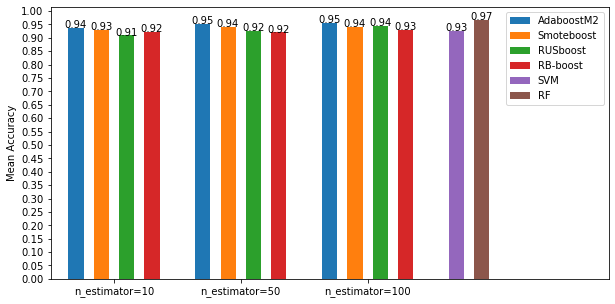

In [31]:
la = {0:'AdaboostM2',3:'Smoteboost',6:'RUSboost',9:'RB-boost'}
plt.figure(figsize=(10,5))
for i in np.arange(0,12,step=3):
    plt.bar(x[i:i+3],accs[i:i+3],width=.6,label=la[i])

plt.bar(x[12],accs[12],width=.6,label = 'SVM')
plt.bar(x[13],accs[13],width=.6,label = 'RF')
plt.legend()
plt.xlim(0,22)
plt.xticks([2.5,7.5,12.5],['n_estimator=10','n_estimator=50','n_estimator=100'])
# plt.title('Mean ACCs.')
plt.ylabel('Mean Accuracy')
plt.yticks(np.arange(0,1.01,.05))

for i,v in enumerate(x):
    plt.text(v-.45,accs[i],round(accs[i],2))

plt.show()

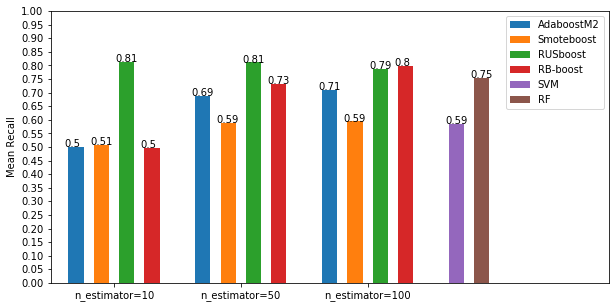

In [32]:
la = {0:'AdaboostM2',3:'Smoteboost',6:'RUSboost',9:'RB-boost'}
plt.figure(figsize=(10,5))
for i in np.arange(0,12,step=3):
    plt.bar(x[i:i+3],recs[i:i+3],width=.6,label=la[i])

plt.bar(x[12],recs[12],width=.6,label = 'SVM')
plt.bar(x[13],recs[13],width=.6,label = 'RF')
plt.legend()
plt.xlim(0,22)
plt.xticks([2.5,7.5,12.5],['n_estimator=10','n_estimator=50','n_estimator=100'])
# plt.title('Mean ACCs.')
plt.ylabel('Mean Recall')
plt.yticks(np.arange(0,1.01,.05))

for i,v in enumerate(x):
    plt.text(v-.45,recs[i],round(recs[i],2))

plt.show()

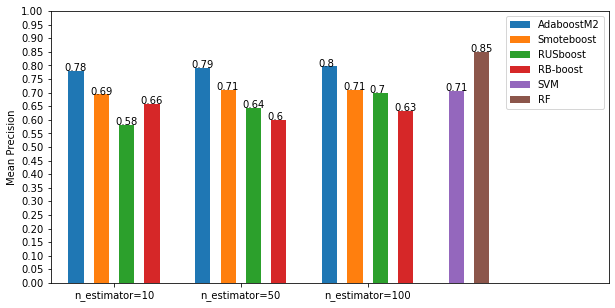

In [33]:
la = {0:'AdaboostM2',3:'Smoteboost',6:'RUSboost',9:'RB-boost'}
plt.figure(figsize=(10,5))
for i in np.arange(0,12,step=3):
    plt.bar(x[i:i+3],pres[i:i+3],width=.6,label=la[i])

plt.bar(x[12],pres[12],width=.6,label = 'SVM')
plt.bar(x[13],pres[13],width=.6,label = 'RF')
plt.legend()
plt.xlim(0,22)
plt.xticks([2.5,7.5,12.5],['n_estimator=10','n_estimator=50','n_estimator=100'])
# plt.title('Mean ACCs.')
plt.ylabel('Mean Precision')
plt.yticks(np.arange(0,1.01,.05))

for i,v in enumerate(x):
    plt.text(v-.45,pres[i],round(pres[i],2))

plt.show()

In [34]:
tp_fp_10 = [adm2_tp_fp[10],sadm2_tp_fp[10],rus_tp_fp[10],rb_tp_fp[10],svm_tp_fp[1],rf_tp_fp[1]]
tp_fp_50 = [adm2_tp_fp[50],sadm2_tp_fp[50],rus_tp_fp[50],rb_tp_fp[50],svm_tp_fp[1],rf_tp_fp[1]]
tp_fp_100 = [adm2_tp_fp[100],sadm2_tp_fp[100],rus_tp_fp[100],rb_tp_fp[100],svm_tp_fp[1],rf_tp_fp[1]]

In [35]:
tp_fp_10[5]

[(array([0.        , 0.02129925, 1.        ]),
  array([0.        , 0.93589744, 1.        ]),
  array([ 2,  1, -1])),
 (array([0.        , 0.00479846, 1.        ]),
  array([0.        , 0.60377358, 1.        ]),
  array([ 2,  1, -1])),
 (array([0.        , 0.00773694, 1.        ]),
  array([0.        , 0.56666667, 1.        ]),
  array([ 2,  1, -1])),
 (array([0.        , 0.01264489, 1.        ]),
  array([0.        , 0.80689655, 1.        ]),
  array([ 2,  1, -1])),
 (array([0.        , 0.03688093, 1.        ]),
  array([0.        , 0.85517241, 1.        ]),
  array([ 2,  1, -1]))]

In [36]:
mean_tp_fp_10 = []
mean_tp_fp_50 = []
mean_tp_fp_100 = []
for item in tp_fp_10:
    mean_tp_fp_10.append(np.mean(item,axis=0))
for item in tp_fp_50:
    mean_tp_fp_50.append(np.mean(item,axis=0))
for item in tp_fp_100:
    mean_tp_fp_100.append(np.mean(item,axis=0))

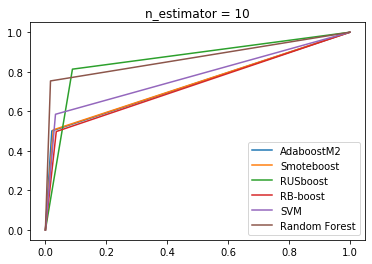

In [37]:
la = {0:'AdaboostM2',1:'Smoteboost',2:'RUSboost',3:'RB-boost',4:'SVM',5:'Random Forest'}
plt.title("n_estimator = 10")
i = -1
for item in mean_tp_fp_10:
    i +=1
    plt.plot(item[0],item[1],label = la[i])
    plt.legend()
    

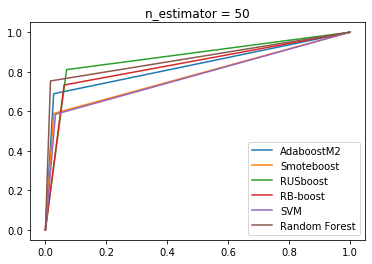

In [38]:
plt.title("n_estimator = 50")
i = -1
for item in mean_tp_fp_50:
    i +=1
    plt.plot(item[0],item[1],label = la[i])
    plt.legend()

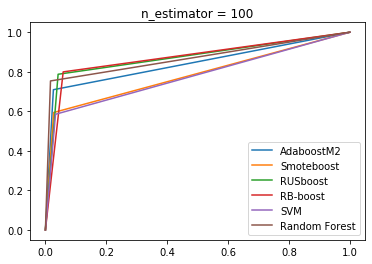

In [39]:
plt.title("n_estimator = 100")
i = -1
for item in mean_tp_fp_100:
    i +=1
    plt.plot(item[0],item[1],label = la[i])
    plt.legend()

In [40]:
a = []
s = []
ru = []
rb = []
sv = []
rf = []
for i in range(10):
    Xtr,Xte,ytr,yte = train_test_split(Data,Labels,test_size=.3)
    LSVM = LinearSVC(C = 1.0,max_iter=100)
    LSVM.fit(Xtr,ytr)
    sv.append(accuracy_score(yte,LSVM.predict(Xte)))
    rfc = RandomForestClassifier()
    rfc.fit(Xtr,ytr)
    rf.append(accuracy_score(yte,rfc.predict(Xte)))
    abom2 = ADABOOST_M2(Xtr,ytr)
    abom2.train(100)
    a.append(accuracy_score(yte,abom2.predict(Xte)))
    sbo = SMOTE_BOOST(Xtr,ytr,10,900)
    sbo.train(100)
    s.append(accuracy_score(yte,sbo.predict(Xte)))
    rubo = RUSBOOST(Xtr,ytr,50)
    rubo.train(100)
    ru.append(accuracy_score(yte,rubo.predict(Xte)))
    rbbo = RB_BOOST(Xtr,ytr)
    rbbo.train(5,100)
    rb.append(accuracy_score(yte,rbbo.predict(Xte)))
      

d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\iust\pattern\projects\2\2venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [41]:
print(a,s,ru,rb,sv,rf)
#ada smote rus ran_bal svm ran_for

[0.9646772228989038, 0.9689403166869671, 0.9646772228989038, 0.964068209500609, 0.9683313032886723, 0.9610231425091352, 0.9646772228989038, 0.9671132764920828, 0.9671132764920828, 0.9628501827040195] [0.9354445797807551, 0.9372716199756395, 0.9336175395858709, 0.9403166869671132, 0.9317904993909866, 0.9323995127892813, 0.9518879415347138, 0.9464068209500609, 0.9457978075517661, 0.940925700365408] [0.9579780755176613, 0.9555420219244823, 0.9439707673568819, 0.9598051157125457, 0.9439707673568819, 0.940925700365408, 0.9500609013398295, 0.9561510353227771, 0.9567600487210719, 0.9561510353227771] [0.9263093788063338, 0.9506699147381242, 0.9366626065773447, 0.925700365408039, 0.9311814859926918, 0.9354445797807551, 0.9311814859926918, 0.9451887941534713, 0.9451887941534713, 0.9476248477466505] [0.9342265529841657, 0.9427527405602923, 0.9348355663824605, 0.8781973203410475, 0.7978075517661388, 0.9250913520097442, 0.940925700365408, 0.9549330085261876, 0.9013398294762485, 0.951278928136419] [

In [42]:
obs = np.concatenate((a,s,ru,rb,sv,rf)).reshape(6,10)
obs
# np.round(obs,2)
# np.mean(obs,axis=1)

array([[0.96467722, 0.96894032, 0.96467722, 0.96406821, 0.9683313 ,
        0.96102314, 0.96467722, 0.96711328, 0.96711328, 0.96285018],
       [0.93544458, 0.93727162, 0.93361754, 0.94031669, 0.9317905 ,
        0.93239951, 0.95188794, 0.94640682, 0.94579781, 0.9409257 ],
       [0.95797808, 0.95554202, 0.94397077, 0.95980512, 0.94397077,
        0.9409257 , 0.9500609 , 0.95615104, 0.95676005, 0.95615104],
       [0.92630938, 0.95066991, 0.93666261, 0.92570037, 0.93118149,
        0.93544458, 0.93118149, 0.94518879, 0.94518879, 0.94762485],
       [0.93422655, 0.94275274, 0.93483557, 0.87819732, 0.79780755,
        0.92509135, 0.9409257 , 0.95493301, 0.90133983, 0.95127893],
       [0.97563946, 0.97563946, 0.9774665 , 0.97624848, 0.97198538,
        0.97381242, 0.97015834, 0.98112058, 0.97076736, 0.97685749]])

In [43]:
groups_mean = np.mean(obs,axis=1).reshape(-1,1)
ssg = np.sum((obs - groups_mean)**2,axis=0)
#sum of squares within groups
sswg = np.sum(ssg)
sswg

0.02221166813294741

In [44]:
total_mean = np.mean(obs)
sst = np.sum((obs - total_mean)**2)

In [45]:
#sum of squares between groups
ssbg = sst - sswg
ssbg

0.02240319332701324

In [46]:
m1 = ssbg/(10-1)
m1

0.002489243703001471

In [47]:
#sum of squares within groups
m2 = sswg/(60-10)
m2

0.0004442333626589482

In [48]:
F_9_50 = m1/m2
F_9_50

5.603459605334823

In [49]:
from scipy.stats import sem,t

def independent_ttest(a, b, alpha):
    # calculate means
    n = len(a)
    # calculate standard errors
    se1, se2 = np.std(a, ddof=1)/np.sqrt(n), np.std(b, ddof=1)/np.sqrt(n)
    sed = np.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (np.mean(a) - np.mean(b)) / sed
    # degrees of freedom
    df=len(a) + len(b) - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    p = (1.0 - t.cdf(np.abs(t_stat), df)) * 2.0
    # return everything
    return t_stat,cv,p


In [50]:
sames = []
sames2 = []
alpha = .01
#ada smote rus ran_bal svm ran_for
for i in range(4):
    for j in range(i+1,5):
        ts,cv,p = independent_ttest(obs[i],obs[j],alpha)
        if p>alpha:
            sames.append((i,j))
        if ts<=cv:
            sames2.append((i,j))
sames

[(1, 3), (1, 4), (2, 4), (3, 4)]

In [51]:
from scipy import stats

ts,cv,p = independent_ttest(obs[1],obs[2],0.01)
ts2, p2 = stats.ttest_ind(obs[1],obs[2])


In [52]:
print(ts,ts2)
print(p,p2)

-4.12918618754692 -4.12918618754692
0.0006299656682293708 0.0006299656682292566
